In [162]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import scipy.signal
import numpy as np

In [163]:
# import cow data
df_cow = pd.read_csv('day_1_data.csv')

# check if there is null values
df_cow.isnull().sum()

# select only gyro and accelerometer data
res = df_cow.iloc[:,1:7]

#  Run fft analysis to see the major frequency content of selected features

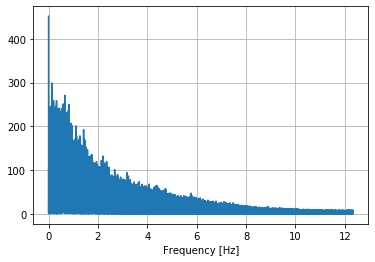

In [164]:

from scipy.fftpack import fft, fftfreq

# Number of sample points
def run_fft(res,feature):

    N = len(res)
    # sample spacing
    T = 24*60*60/N
    
    x = np.linspace(0.0, 24*60*60, len(res), endpoint=False)
    
    y = res.iloc[:,0].values
    yf = fft(y)
    xf = fftfreq(N, T)[:N//2]
    
    
    plt.plot(xf, 2.0/N * np.abs(yf[0:N//2]))
    plt.xlabel('Frequency [Hz]')
    plt.grid()
    plt.show()
    
run_fft(res,feature= 5)

### Filter the data with a butterworth low pass filter to reduce noise and cancell out the gravitational component of the acceleration. The cut off frequency was set to 2Hz because most prominant frequency components are below 2Hz. Given that the raw data is a relextion of cow activities of walking, running, eating, ruminating, and sleeping. It makes sense that high fequency acitvity is limited. 

In [165]:
from scipy.signal import butter,filtfilt


def butter_lowpass_filter(data, cutoff, fs, order):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    # Get the filter coefficients 
    b, a = butter(order, normal_cutoff, btype='low', analog=False,output='ba')
    y = filtfilt(b, a, data)
    return y


# set Filter requirements.
order = 6
fs = 25     # sample rate, Hz
cutoff =  2 # desired cutoff frequency of the filter, Hz


T = 24*60*60         # seconds
n = len(res) # total number of samples
t = np.linspace(0, T, n, endpoint=False)


# Filter the data for individual features

y = [pd.DataFrame(butter_lowpass_filter(res[column], cutoff, fs, order).reshape(-1,1)) for column in res.columns]

df_fil = pd.concat(y,axis = 1)
df_fil.columns = res.columns

### Plot the first 300 original data and filtered data in selected feature. The filtered data well captures the shape of the raw data.

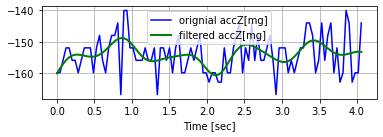

In [166]:
# plot the first 300 original data and filtered data in selected feature 

data_points = 100
feature_ind = 5

data = res.loc[:data_points,:].iloc[:,feature_ind]
data_fil = df_fil.loc[:data_points,].iloc[:,feature_ind]

plt.subplot(2, 1, 2)
plt.plot(t[:data_points+1], data, 'b-', label='orignial %s'%res.columns[feature_ind])
plt.plot(t[:data_points+1], data_fil, 'g-', linewidth=2, label='filtered %s'%df_fil.columns[feature_ind])
plt.xlabel('Time [sec]')
plt.grid()
plt.legend()

plt.subplots_adjust(hspace=0.35)
plt.show()

### Plot some data with 3 features in 3D. We can see that the majority of data are not separatable.

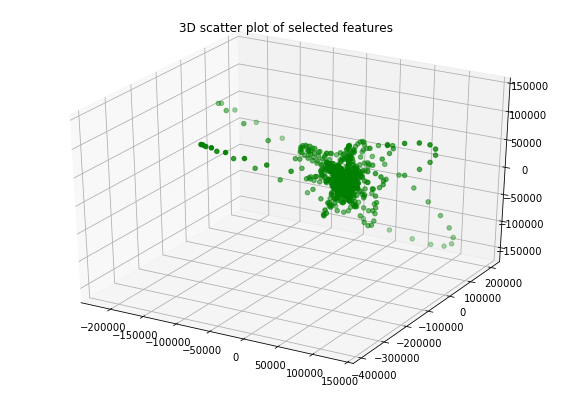

In [167]:
from mpl_toolkits import mplot3d

data_points = 10000
x = df_fil.loc[:data_points,].iloc[:,0]
y = df_fil.loc[:data_points,].iloc[:,1]
z = df_fil.loc[:data_points,].iloc[:,2]
# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, color = "green")
plt.title("3D scatter plot of selected features")
 
# show plot
plt.show()

### Sampled in fixed-width sliding windows of 128 points and 50% overlap and delete the nan values

In [168]:
# extract features

window_size = 128

df_roll = df_fil.rolling(window_size,center = True).mean()[int(window_size/2)::int(window_size/2)] 
#df_roll[4::5] 

df_roll = df_roll.dropna() # delete rows containing nan values


### Normalized the features between -1 to 1 and plot a few data 

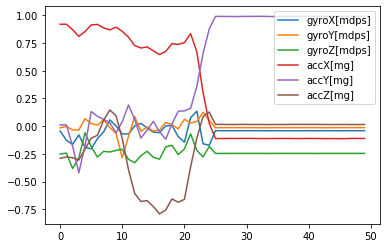

In [170]:
# Normalize features 
scaler = MinMaxScaler(feature_range=(-1, 1))
scaled = scaler.fit_transform(df_roll.values)
df_scaled = pd.DataFrame(scaled,columns = df_roll.columns)


ax = plt.gca()
for column in res.columns:

    df_scaled.head(50).plot(kind= 'line',y = column,ax=ax)

### Finding the peaks in selected feature (e.g. gyroX) might help distinguish different activities but the values need to be further justified.

In [13]:
import scipy.ndimage.filters as filters
import scipy.signal as signal
import numpy as np

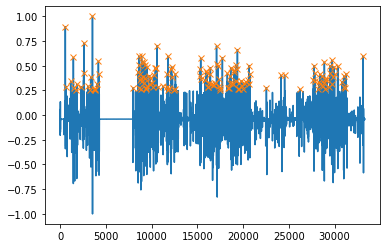

In [150]:
feature_ind = 0

arr_scaled= df_scaled.iloc[:,feature_ind].values


peak_idx, properties = signal.find_peaks(arr_scaled, distance=30,height = 0.25)
peak_width = signal.peak_widths(arr_scaled, 
                                    peak_idx, 
                                    rel_height=1.0)[0].astype(int)


plt.plot(arr_scaled)
plt.plot(peak_idx, arr_scaled[peak_idx], "x")

plt.show()

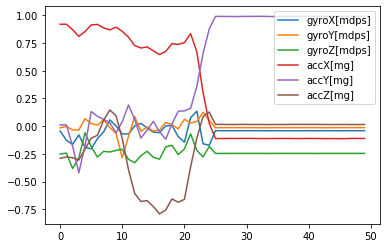

In [142]:
%matplotlib inline

ax = plt.gca()
for column in res.columns:

    df_scaled.head(50).plot(kind= 'line',y = column,ax=ax)


### K-means clustering is a popular way to partition abservations into k clusters. 

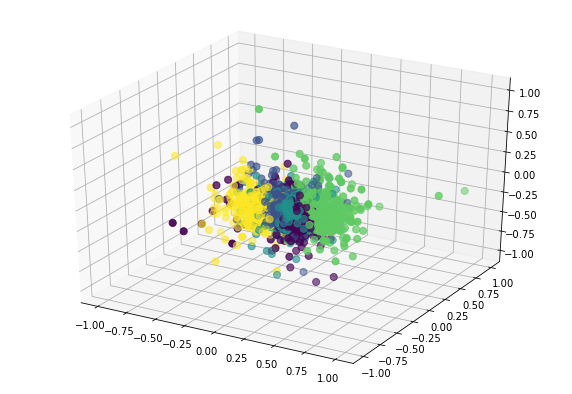

In [160]:
from sklearn.cluster import KMeans
#X = df_scaled[['gyroX[mdps]','accX[mg]']].head(5000)
#X = df_scaled['gyroX[mdps]'].values.reshape(-1,1)
X = df_scaled[['gyroX[mdps]','gyroY[mdps]','gyroZ[mdps]']]

kmeans = KMeans(n_clusters=5).fit(X)

y_kmeans = kmeans.predict(X)


x = X.iloc[:, 0]
y = X.iloc[:, 1]
z = X.iloc[:, 2]

# Creating figure
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")
 
# Creating plot
ax.scatter3D(x, y, z, c=y_kmeans, s=50, cmap='viridis')
centers = kmeans.cluster_centers_
ax.scatter3D(centers[:, 0], centers[:, 1], centers[:, 2],  c='purple', s=200, alpha=0.5)

 
# show plot
plt.show()

